Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Training Baseline CNN...
Baseline CNN Epoch [10/200], Loss: 0.7475, Accuracy: 71.64%
Baseline CNN Epoch [20/200], Loss: 0.6020, Accuracy: 75.97%
Baseline CNN Epoch [30/200], Loss: 0.5309, Accuracy: 76.92%
Baseline CNN Epoch [40/200], Loss: 0.4831, Accuracy: 77.64%
Baseline CNN Epoch [50/200], Loss: 0.4475, Accuracy: 77.98%
Baseline CNN Epoch [60/200], Loss: 0.4232, Accuracy: 77.88%
Baseline CNN Epoch [70/200], Loss: 0.4047, Accuracy: 78.30%
Baseline CNN Epoch [80/200], Loss: 0.3794, Accuracy: 79.13%
Baseline CNN Epoch [90/200], Loss: 0.3719, Accuracy: 78.07%
Baseline CNN Epoch [100/200], Loss: 0.3549, Accuracy: 78.79%
Baseline CNN Epoch [110/200], Loss: 0.3498, Accuracy: 79.02%
Baseline CNN Epoch [120/200], Loss: 0.3410, Accuracy: 79.17%
Baseline CNN Epoch [130/200], Loss: 0.3252, Accuracy: 79.71%
Baseline CNN Epoch [140/200], Loss: 0.3149, Accuracy: 79.73%
Baseline CNN Epoch [150/200], Loss: 0.30

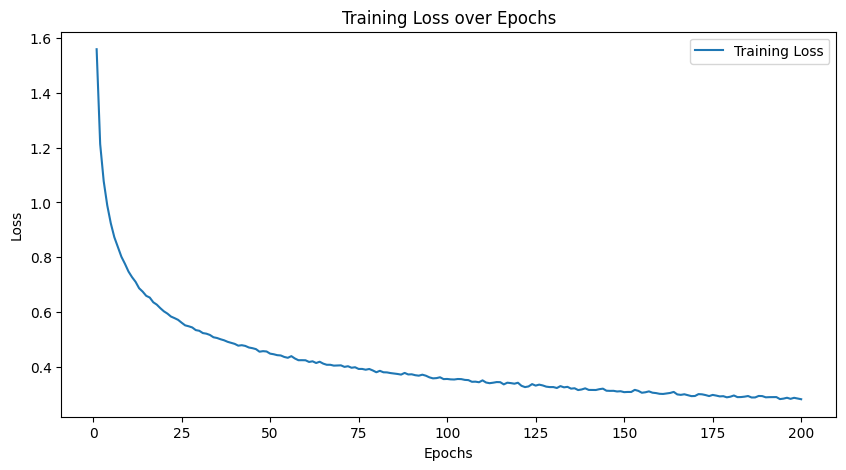

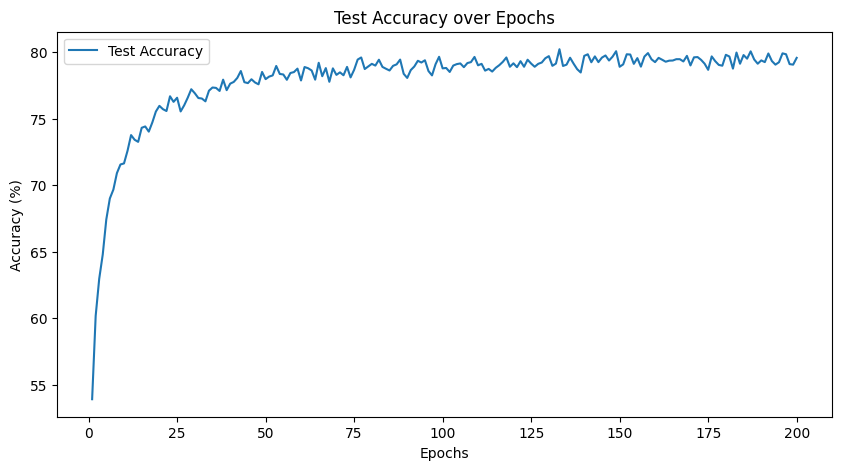

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Define hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 200
report_interval = 10  # How often to print training progress

# Define data transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Normalize using CIFAR-10 means
                       (0.2470, 0.2435, 0.2616))    # and standard deviations
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders for batch processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the CNN architecture
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # First convolutional layer: 3 input channels, 32 output channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()  # Activation function
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # First FC layer
        self.fc2 = nn.Linear(256, 10)  # Output layer (10 classes for CIFAR-10)

    def forward(self, x):
        # Apply first conv layer, ReLU activation, and pooling
        x = self.pool(self.relu(self.conv1(x)))
        # Apply second conv layer, ReLU activation, and pooling
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 8 * 8)
        # Apply first fully connected layer with ReLU
        x = self.relu(self.fc1(x))
        # Apply final fully connected layer
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("\nTraining Baseline CNN...")
start_time = time.time()

# Lists to store training history
baseline_epoch_losses = []
baseline_epoch_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    # Train on batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    # Calculate average epoch loss
    epoch_loss = running_loss / len(train_loader.dataset)
    baseline_epoch_losses.append(epoch_loss)
    
    # Evaluate on test set
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store accuracy
    accuracy = 100.0 * correct / total
    baseline_epoch_accuracies.append(accuracy)
    
    # Print progress
    if (epoch + 1) % report_interval == 0:
        print(f"Baseline CNN Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Calculate and print final statistics
end_time = time.time()
baseline_training_time = end_time - start_time
baseline_final_loss = baseline_epoch_losses[-1]
baseline_final_accuracy = baseline_epoch_accuracies[-1]
baseline_params = sum(p.numel() for p in model.parameters())

print("Baseline CNN:")
print(f"Baseline CNN Total Training Time: {baseline_training_time/60:.2f} minutes")
print(f" - Final Training Loss: {baseline_final_loss:.4f}")
print(f" - Final Test Accuracy: {baseline_final_accuracy:.2f}%")
print(f" - Number of Parameters: {baseline_params}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), baseline_epoch_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), baseline_epoch_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()


Training Extended CNN...
Extended CNN Epoch [10/200], Loss: 0.6357, Accuracy: 74.35%
Extended CNN Epoch [20/200], Loss: 0.4741, Accuracy: 78.99%
Extended CNN Epoch [30/200], Loss: 0.3977, Accuracy: 79.77%
Extended CNN Epoch [40/200], Loss: 0.3482, Accuracy: 80.92%
Extended CNN Epoch [50/200], Loss: 0.3107, Accuracy: 80.90%
Extended CNN Epoch [60/200], Loss: 0.2863, Accuracy: 80.74%
Extended CNN Epoch [70/200], Loss: 0.2630, Accuracy: 81.47%
Extended CNN Epoch [80/200], Loss: 0.2503, Accuracy: 80.37%
Extended CNN Epoch [90/200], Loss: 0.2329, Accuracy: 81.66%
Extended CNN Epoch [100/200], Loss: 0.2221, Accuracy: 82.20%
Extended CNN Epoch [110/200], Loss: 0.2152, Accuracy: 82.11%
Extended CNN Epoch [120/200], Loss: 0.2072, Accuracy: 82.06%
Extended CNN Epoch [130/200], Loss: 0.1997, Accuracy: 82.13%
Extended CNN Epoch [140/200], Loss: 0.1900, Accuracy: 82.70%
Extended CNN Epoch [150/200], Loss: 0.1930, Accuracy: 81.89%
Extended CNN Epoch [160/200], Loss: 0.1825, Accuracy: 82.49%
Extende

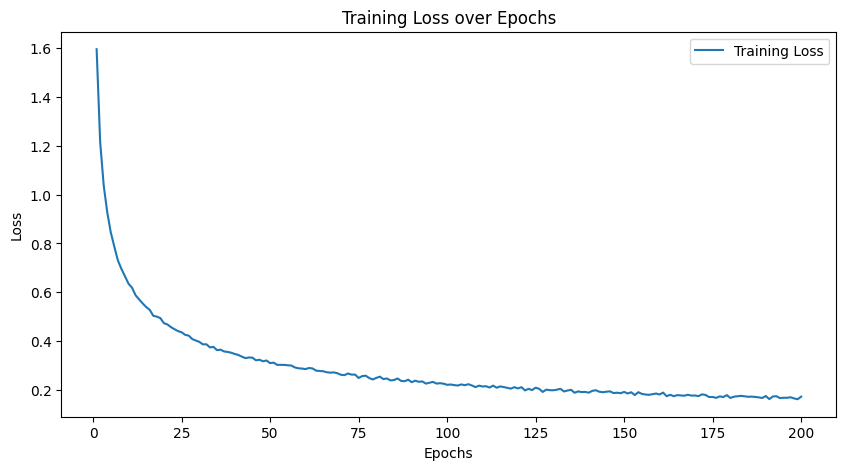

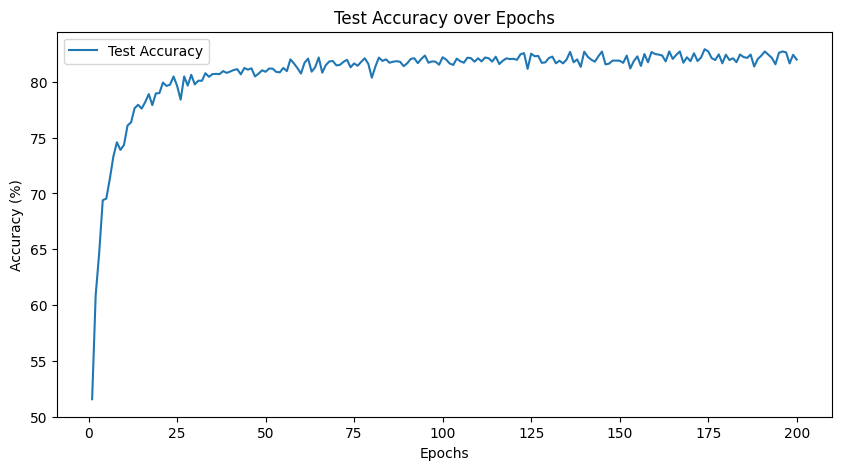

In [6]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# Define deeper CNN architecture with an additional convolutional layer
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Third convolutional layer: 64 input channels, 128 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Max pooling layer for spatial dimension reduction
        self.pool = nn.MaxPool2d(2, 2)
        # ReLU activation function
        self.relu = nn.ReLU()
        # First fully connected layer: input size calculated based on conv output
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        # Output layer: 256 to 10 classes (CIFAR-10)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Apply first conv layer followed by ReLU and pooling
        x = self.pool(self.relu(self.conv1(x)))
        # Apply second conv layer followed by ReLU and pooling
        x = self.pool(self.relu(self.conv2(x)))
        # Apply third conv layer followed by ReLU and pooling
        x = self.pool(self.relu(self.conv3(x)))
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        # Apply first fully connected layer with ReLU
        x = self.relu(self.fc1(x))
        # Apply final fully connected layer
        x = self.fc2(x)
        return x

# Initialize the deeper model and move it to the specified device (GPU/CPU)
model_deeper = DeeperCNN().to(device)
# Define loss function (Cross Entropy for classification)
criterion = nn.CrossEntropyLoss()
# Define optimizer (Adam) with specified learning rate
optimizer = optim.Adam(model_deeper.parameters(), lr=learning_rate)

print("\nTraining Extended CNN...")
start_time = time.time()

# Lists to store training history
extended_epoch_losses = []
extended_epoch_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model_deeper.train()
    running_loss = 0.0
    
    # Train on batches
    for images, labels in train_loader:
        # Move data to specified device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_deeper(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        running_loss += loss.item() * images.size(0)
    
    # Calculate average epoch loss
    epoch_loss = running_loss / len(train_loader.dataset)
    extended_epoch_losses.append(epoch_loss)
    
    # Evaluate on test set
    model_deeper.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_deeper(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store accuracy
    accuracy = 100.0 * correct / total
    extended_epoch_accuracies.append(accuracy)
    
    # Print progress at specified intervals
    if (epoch + 1) % report_interval == 0:
        print(f"Extended CNN Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Calculate and print final statistics
end_time = time.time()
extended_training_time = end_time - start_time
extended_final_loss = extended_epoch_losses[-1]
extended_final_accuracy = extended_epoch_accuracies[-1]
extended_params = sum(p.numel() for p in model_deeper.parameters())

print("Extended CNN:")
print(f"Extended CNN Total Training Time: {extended_training_time/60:.2f} minutes")
print(f" - Final Training Loss: {extended_final_loss:.4f}")
print(f" - Final Test Accuracy: {extended_final_accuracy:.2f}%")
print(f" - Number of Parameters: {extended_params}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), extended_epoch_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), extended_epoch_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()

Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Training ResNet-10 on CIFAR-10...
Epoch [10/200], Loss: 0.3445, Accuracy: 84.61%
Epoch [20/200], Loss: 0.1660, Accuracy: 89.28%
Epoch [30/200], Loss: 0.0879, Accuracy: 90.11%
Epoch [40/200], Loss: 0.0596, Accuracy: 90.80%
Epoch [50/200], Loss: 0.0376, Accuracy: 91.42%
Epoch [60/200], Loss: 0.0294, Accuracy: 90.98%
Epoch [70/200], Loss: 0.0244, Accuracy: 91.47%
Epoch [80/200], Loss: 0.0225, Accuracy: 91.88%
Epoch [90/200], Loss: 0.0187, Accuracy: 91.62%
Epoch [100/200], Loss: 0.0150, Accuracy: 91.97%
Epoch [110/200], Loss: 0.0150, Accuracy: 91.92%
Epoch [120/200], Loss: 0.0149, Accuracy: 92.35%
Epoch [130/200], Loss: 0.0138, Accuracy: 92.69%
Epoch [140/200], Loss: 0.0125, Accuracy: 92.22%
Epoch [150/200], Loss: 0.0112, Accuracy: 92.11%
Epoch [160/200], Loss: 0.0110, Accuracy: 92.41%
Epoch [170/200], Loss: 0.0082, Accuracy: 92.18%
Epoch [180/200], Loss: 0.0075, Accuracy: 92.20%
Epoch [190/200], Loss

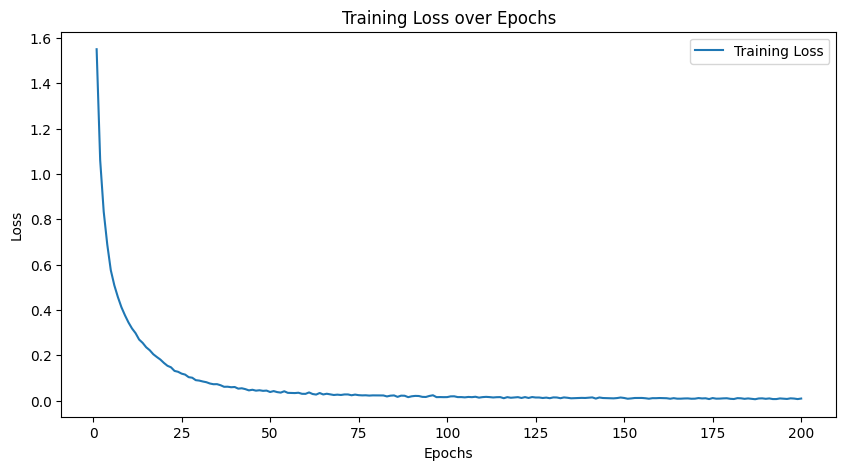

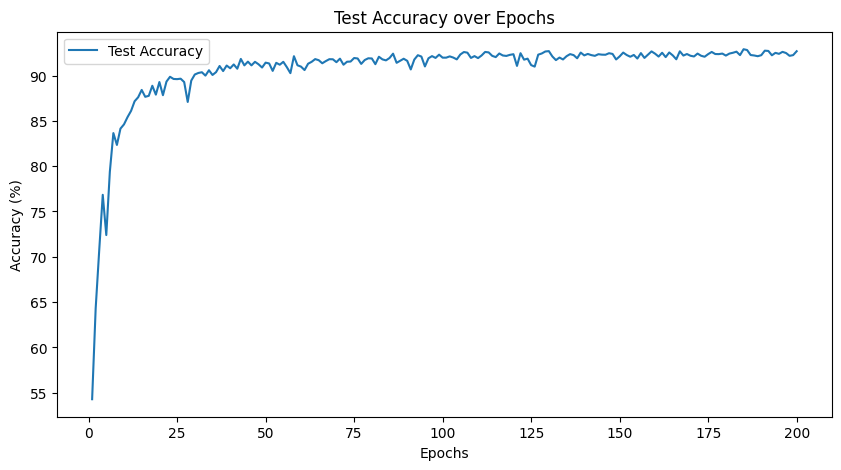

In [ ]:

# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Define hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 200
report_interval = 10

# Define data transformations for augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Normalize using CIFAR-10 means
                       (0.2470, 0.2435, 0.2616))    # and standard deviations
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the basic building block for ResNet
class BasicBlock(nn.Module):
    expansion = 1  # Factor by which channels increase in this block

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  # Batch normalization after first conv
        self.relu = nn.ReLU(inplace=True)  # ReLU activation
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)  # Batch normalization after second conv

        # Shortcut connection (identity mapping or 1x1 conv)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            # If dimensions change, adjust shortcut with 1x1 conv
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        # Main path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Add shortcut to main path
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Create ResNet layers
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global average pooling and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """Helper function to create a layer of sequential blocks"""
        strides = [stride] + [1]*(num_blocks-1)  # First block may downsample
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and batch norm
        x = self.relu(self.bn1(self.conv1(x)))
        # Forward through ResNet blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Global average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize ResNet-10 model ([3,3,2,2] configuration)
model = ResNet(BasicBlock, [3,3,2,2]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("\nTraining ResNet-10 on CIFAR-10...")
start_time = time.time()

# Lists to store training history
epoch_losses = []
epoch_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass and optimization
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)

    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store accuracy
    accuracy = 100.0 * correct / total
    epoch_accuracies.append(accuracy)

    # Print progress
    if (epoch + 1) % report_interval == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Calculate final statistics
end_time = time.time()
training_time = end_time - start_time
final_loss = epoch_losses[-1]
final_accuracy = epoch_accuracies[-1]
model_params = sum(p.numel() for p in model.parameters())

# Print final results
print("ResNet-10:")
print(f"\nResNet-10 Total Training Time: {training_time/60:.2f} minutes")
print(f" - Final Training Loss: {final_loss:.4f}")
print(f" - Final Test Accuracy: {final_accuracy:.2f}%")
print(f" - Number of Parameters: {model_params}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()